In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = '/content/drive/MyDrive/final-year-project'
os.makedirs(f'{project_path}/data/raw', exist_ok=True)
os.makedirs(f'{project_path}/data/processed', exist_ok=True)
os.chdir(project_path)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

def download_season(season, league_code, league_name):
    """Download a single season"""
    url = f"https://www.football-data.co.uk/mmz4281/{season}/{league_code}.csv"
    try:
        df = pd.read_csv(url)
        df['Season'] = season
        df['League'] = league_name
        print(f"✓ {league_name} {season}: {len(df)} matches")
        return df
    except:
        print(f"✗ Failed: {league_name} {season}")
        return None

all_data = []
seasons = ['1819', '1920', '2021', '2122', '2223', '2324', '2425']
leagues = {'E0': 'Premier League', 'D1': 'Bundesliga', 'SP1': 'La Liga'}

for season in seasons:
    for code, name in leagues.items():
        df = download_season(season, code, name)
        if df is not None:
            all_data.append(df)

full_df = pd.concat(all_data, ignore_index=True)
print(f"\n✅ Total: {len(full_df):,} matches downloaded")

✓ Premier League 1819: 380 matches
✓ Bundesliga 1819: 306 matches
✓ La Liga 1819: 380 matches
✓ Premier League 1920: 380 matches
✓ Bundesliga 1920: 306 matches
✓ La Liga 1920: 380 matches
✓ Premier League 2021: 380 matches
✓ Bundesliga 2021: 306 matches
✓ La Liga 2021: 380 matches
✓ Premier League 2122: 380 matches
✓ Bundesliga 2122: 306 matches
✓ La Liga 2122: 380 matches
✓ Premier League 2223: 380 matches
✓ Bundesliga 2223: 306 matches
✓ La Liga 2223: 380 matches
✓ Premier League 2324: 380 matches
✓ Bundesliga 2324: 306 matches
✓ La Liga 2324: 380 matches
✓ Premier League 2425: 380 matches
✓ Bundesliga 2425: 306 matches
✓ La Liga 2425: 380 matches

✅ Total: 7,462 matches downloaded


In [4]:
!git clone https://github.com/Omarali19/final-year-project.git

%cd final-year-project


fatal: destination path 'final-year-project' already exists and is not an empty directory.
/content/drive/MyDrive/final-year-project/final-year-project


In [5]:
import pandas as pd
import numpy as np
import os

print("=== Checking Downloaded Data ===")

data_files = os.listdir('data/raw')
print(f"Found {len(data_files)} files in data/raw/:")
for file in data_files[:10]:
    print(f"  - {file}")

sample_file = data_files[0]
sample_df = pd.read_csv(f'data/raw/{sample_file}')
print(f"\nSample file: {sample_file}")
print(f"Shape: {sample_df.shape}")
print(f"Columns: {list(sample_df.columns)}")

=== Checking Downloaded Data ===
Found 22 files in data/raw/:
  - .gitkeep
  - Bundesliga 2018 2019.csv
  - Bundesliga 2019 2020.csv
  - Bundesliga 2020 2021.csv
  - Bundesliga 2021 2022.csv
  - Bundesliga 2022 2023.csv
  - Bundesliga 2023 2024.csv
  - Bundesliga 2024 2025.csv
  - La Liga 2018 2019.csv
  - La Liga 2019 2020.csv

Sample file: .gitkeep
Shape: (0, 1)
Columns: ['# Placeholder file to keep folder in Git']


In [6]:
# src/preprocessing.py

import pandas as pd
import numpy as np
from datetime import datetime

def preprocess_football_data(df, season, league_name):
    """
    Clean and preprocess a football dataset

    Parameters:
    -----------
    df : pandas DataFrame
        Raw football data
    season : str
        Season code (e.g., '2324')
    league_name : str
        Name of the league

    Returns:
    --------
    pandas DataFrame
        Cleaned and processed data
    """

    df_clean = df.copy()

    # Step 1: Adding metadata
    df_clean['Season'] = season
    df_clean['League'] = league_name

    # Step 2: Standardising column names
    df_clean.columns = df_clean.columns.str.strip().str.lower()

    # Step 3: Fixing the date column
    if 'date' in df_clean.columns:
        try:
            df_clean['date'] = pd.to_datetime(df_clean['date'], dayfirst=True)
        except:
            try:
                df_clean['date'] = pd.to_datetime(df_clean['date'])
            except:
                df_clean['date'] = pd.NaT

    # Step 4: Creating the target variable (Match Result)
    if all(col in df_clean.columns for col in ['fthg', 'ftag']):
        conditions = [
            df_clean['fthg'] > df_clean['ftag'],  # Home win
            df_clean['fthg'] == df_clean['ftag'], # Draw
            df_clean['fthg'] < df_clean['ftag']   # Away win
        ]
        choices = ['H', 'D', 'A']
        df_clean['match_result'] = np.select(conditions, choices, default='Unknown')

       # Creating the numeric versions (0=Draw, 1=Home Win, 2=Away Win)
        df_clean['result_numeric'] = np.where(df_clean['fthg'] > df_clean['ftag'], 1,
                                            np.where(df_clean['fthg'] == df_clean['ftag'], 0, 2))

    # Step 5: Creating useful features
    # Goal difference
    if all(col in df_clean.columns for col in ['fthg', 'ftag']):
        df_clean['goal_difference'] = df_clean['fthg'] - df_clean['ftag']
        df_clean['total_goals'] = df_clean['fthg'] + df_clean['ftag']

    # Shots on target percentage
    if all(col in df_clean.columns for col in ['hs', 'hst']):
        df_clean['home_shot_accuracy'] = df_clean['hst'] / df_clean['hs'].replace(0, np.nan)
    if all(col in df_clean.columns for col in ['as', 'ast']):
        df_clean['away_shot_accuracy'] = df_clean['ast'] / df_clean['as'].replace(0, np.nan)

    # Step 6: Handling missing values
    # For numeric columns, filling with 0 or median
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col not in ['fthg', 'ftag', 'result_numeric']:
            df_clean[col] = df_clean[col].fillna(0)

    # Step 7: Creating relevant columns
    core_columns = [
        'date', 'hometeam', 'awayteam', 'fthg', 'ftag',
        'hs', 'as', 'hst', 'ast', 'hc', 'ac', 'hf', 'af',
        'hy', 'ay', 'hr', 'ar', 'b365h', 'b365d', 'b365a',
        'match_result', 'result_numeric', 'goal_difference', 'total_goals',
        'season', 'league'
    ]

    existing_columns = [col for col in core_columns if col in df_clean.columns]
    df_clean = df_clean[existing_columns]

    return df_clean

def merge_all_datasets(data_dir='data/raw'):
    """
    Load, preprocess, and merge all football datasets

    Parameters:
    -----------
    data_dir : str
        Directory containing raw CSV files

    Returns:
    --------
    pandas DataFrame
        Combined and cleaned dataset
    """
    all_data = []

    league_codes = {
        'E0': 'Premier League',
        'D1': 'Bundesliga',
        'SP1': 'La Liga',
        'I1': 'Serie A',
        'F1': 'Ligue 1'
    }

    # Processing each file
    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            try:
                filename = file.replace('.csv', '')
                season = None
                league = None

                if '_' in filename:
                    parts = filename.split('_')
                    if len(parts) >= 2:
                        league_part = parts[0]
                        season_part = parts[-1]

                        league = league_codes.get(league_part, league_part)

                        if len(season_part) == 4 and season_part.isdigit():
                            season = season_part
                if not season:
                    season = '2324'
                if not league:
                    league = 'Unknown League'

                # Loading and preprocessing
                filepath = os.path.join(data_dir, file)
                raw_df = pd.read_csv(filepath)

                print(f"Processing {file} -> {league} {season}")

                cleaned_df = preprocess_football_data(raw_df, season, league)
                all_data.append(cleaned_df)

            except Exception as e:
                print(f"Error processing {file}: {str(e)}")

    # Combining all the data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n✅ Successfully combined {len(all_data)} datasets")
        print(f"Total matches: {len(combined_df):,}")
        return combined_df
    else:
        print("❌ No data was processed successfully")
        return pd.DataFrame()

In [7]:
import os

preprocessing_code = '''
"""
preprocessing.py
Football data preprocessing functions
"""

import pandas as pd
import numpy as np
import os

def preprocess_football_data(df, season, league_name):
    """
    Clean and preprocess football data
    """
    df_clean = df.copy()

    df_clean[\'Season\'] = season
    df_clean[\'League\'] = league_name

    df_clean.columns = df_clean.columns.str.strip().str.lower()

    if \'date\' in df_clean.columns:
        try:
            df_clean[\'date\'] = pd.to_datetime(df_clean[\'date\'], dayfirst=True)
        except:
            df_clean[\'date\'] = pd.to_datetime(df_clean[\'date\'])

    if all(col in df_clean.columns for col in [\'fthg\', \'ftag\']):
        df_clean[\'match_result\'] = np.where(df_clean[\'fthg\'] > df_clean[\'ftag\'], \'H\',
                                            np.where(df_clean[\'fthg\'] == df_clean[\'ftag\'], \'D\', \'A\'))
        df_clean[\'result_numeric\'] = np.where(df_clean[\'fthg\'] > df_clean[\'ftag\'], 1,
                                              np.where(df_clean[\'fthg\'] == df_clean[\'ftag\'], 0, 2))

    if all(col in df_clean.columns for col in [\'fthg\', \'ftag\']):
        df_clean[\'goal_difference\'] = df_clean[\'fthg\'] - df_clean[\'ftag\']
        df_clean[\'total_goals\'] = df_clean[\'fthg\'] + df_clean[\'ftag\']

    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col not in [\'fthg\', \'ftag\', \'result_numeric\']:
            df_clean[col] = df_clean[col].fillna(0)

    # Select columns to keep
    core_columns = [
        \'date\', \'hometeam\', \'awayteam\', \'fthg\', \'ftag\',
        \'hs\', \'as\', \'hst\', \'ast\', \'hc\', \'ac\',
        \'match_result\', \'result_numeric\', \'goal_difference\', \'total_goals\',
        \'season\', \'league\'
    ]

    existing_columns = [col for col in core_columns if col in df_clean.columns]
    df_clean = df_clean[existing_columns]

    return df_clean

def merge_all_datasets(data_dir=\'data/raw\'):
    """
    Load and merge all datasets
    """
    all_data = []

    for file in os.listdir(data_dir):
        if file.endswith(\'.csv\'):
            try:
                filepath = os.path.join(data_dir, file)
                raw_df = pd.read_csv(filepath)

                filename = file.replace(\'.csv\', \'\')
                season = filename[-4:] if len(filename) >= 4 and filename[-4:].isdigit() else \'2324\'
                league = filename[:-4] if len(filename) > 4 else \'Unknown\'

                league = league.replace(\'_\', \' \').title()
                if \'epl\' in league.lower():
                    league = \'Premier League\'
                elif \'bundle\' in league.lower():
                    league = \'Bundesliga\'
                elif \'laliga\' in league.lower():
                    league = \'La Liga\'

                cleaned_df = preprocess_football_data(raw_df, season, league)
                all_data.append(cleaned_df)
                print(f\"Processed: {file}\")

            except Exception as e:
                print(f\"Skipped {file}: {str(e)[:50]}\")

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    return pd.DataFrame()
'''

os.makedirs('src', exist_ok=True)
with open('src/preprocessing.py', 'w') as f:
    f.write(preprocessing_code)

print("✅ Created src/preprocessing.py")

✅ Created src/preprocessing.py


In [8]:
import sys
sys.path.append('src')

# Try importing
try:
    from preprocessing import merge_all_datasets
    print("✅ Successfully imported preprocessing module!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Check that src/preprocessing.py exists")

    print("\nFiles in src folder:")
    import os
    print(os.listdir('src'))

❌ Import error: No module named 'preprocessing'
Check that src/preprocessing.py exists

Files in src folder:
['__init__.py', 'data_loader.py', 'feature_engineer.py', 'utils.py', 'preprocessing.py', '__pycache__']


In [9]:
print("=== STARTING BATCH PREPROCESSING ===")
print("This will clean and combine ALL your downloaded datasets...")

combined_data = merge_all_datasets('data/raw')

if not combined_data.empty:
    print(f"\n✅ PREPROCESSING COMPLETE!")
    print(f"Total matches processed: {len(combined_data):,}")
    print(f"Total columns: {len(combined_data.columns)}")
    print(f"Date range: {combined_data['date'].min()} to {combined_data['date'].max()}")

    print("\nSample of processed data:")
    print(combined_data[['date', 'hometeam', 'awayteam', 'fthg', 'ftag', 'match_result', 'league']].head()) # Changed 'result' to 'match_result'
else:
    print("\n❌ No data was processed. Check your data/raw folder.")

=== STARTING BATCH PREPROCESSING ===
This will clean and combine ALL your downloaded datasets...
Processing Bundesliga 2018 2019.csv -> Unknown League 2324
Processing Bundesliga 2019 2020.csv -> Unknown League 2324
Processing Bundesliga 2020 2021.csv -> Unknown League 2324
Processing Bundesliga 2021 2022.csv -> Unknown League 2324
Processing Bundesliga 2022 2023.csv -> Unknown League 2324
Processing Bundesliga 2023 2024.csv -> Unknown League 2324
Processing Bundesliga 2024 2025.csv -> Unknown League 2324
Processing La Liga 2018 2019.csv -> Unknown League 2324
Processing La Liga 2019 2020.csv -> Unknown League 2324
Processing La Liga 2020 2021.csv -> Unknown League 2324
Processing La Liga 2021 2022.csv -> Unknown League 2324
Processing La Liga 2022 2023.csv -> Unknown League 2324
Processing La Liga 2023 2024.csv -> Unknown League 2324
Processing La Liga 2024 2025.csv -> Unknown League 2324
Processing Premier League 2018 2019.csv -> Unknown League 2324
Processing Premier League 2019 2020

In [10]:
import os
os.makedirs('data/processed', exist_ok=True)

print("\n=== SAVING PROCESSED DATA ===")

# Step 1: Saving as a CSV file
csv_path = 'data/processed/all_leagues_clean.csv'
combined_data.to_csv(csv_path, index=False)
print(f"✅ CSV saved: {csv_path}")

# Step 2: Saving as Parquet (efficient for large data)
parquet_path = 'data/processed/all_leagues_clean.parquet'
combined_data.to_parquet(parquet_path, index=False)
print(f"✅ Parquet saved: {parquet_path}")

# Step 3: Saving as Pickle (preserves data types)
pkl_path = 'data/processed/all_leagues_clean.pkl'
combined_data.to_pickle(pkl_path)
print(f"✅ Pickle saved: {pkl_path}")

print(f"\nFile sizes:")
print(f"  CSV: {os.path.getsize(csv_path) / 1024 / 1024:.1f} MB")
print(f"  Parquet: {os.path.getsize(parquet_path) / 1024 / 1024:.1f} MB")


=== SAVING PROCESSED DATA ===
✅ CSV saved: data/processed/all_leagues_clean.csv
✅ Parquet saved: data/processed/all_leagues_clean.parquet
✅ Pickle saved: data/processed/all_leagues_clean.pkl

File sizes:
  CSV: 0.9 MB
  Parquet: 0.1 MB


In [11]:
print("=== DATA QUALITY REPORT ===")

# Step 1: Checking for missing values
print("\n1. Missing Values:")
missing = combined_data.isnull().sum()
missing_pct = (missing / len(combined_data) * 100).round(2)
missing_report = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print(missing_report[missing_report['Missing Count'] > 0].sort_values('Missing %', ascending=False))

# Step 2: Checking match result distribution
print("\n2. Match Result Distribution:")
result_counts = combined_data['match_result'].value_counts()
result_pct = combined_data['match_result'].value_counts(normalize=True) * 100
result_report = pd.DataFrame({
    'Count': result_counts,
    'Percentage': result_pct.round(2)
})
print(result_report)

# Step 3: Checking by league
print("\n3. Results by League:")
league_results = pd.crosstab(combined_data['league'], combined_data['match_result'], normalize='index') * 100
print(league_results.round(2))

# Step 4: Basic statistics
print("\n4. Basic Statistics:")
print(f"Total matches: {len(combined_data):,}")
print(f"Unique teams: {combined_data['hometeam'].nunique():,}")
print(f"Seasons covered: {sorted(combined_data['season'].unique())}")
print(f"Leagues: {', '.join(combined_data['league'].unique())}")

=== DATA QUALITY REPORT ===

1. Missing Values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

2. Match Result Distribution:
              Count  Percentage
match_result                   
H              3287       44.05
A              2323       31.13
D              1852       24.82

3. Results by League:
match_result        A      D      H
league                             
Unknown League  31.13  24.82  44.05

4. Basic Statistics:
Total matches: 7,462
Unique teams: 84
Seasons covered: ['2324']
Leagues: Unknown League


In [13]:
import pandas as pd
import numpy as np
import os

import sys
sys.path.append(os.path.join(os.getcwd(), 'src'))
from preprocessing import merge_all_datasets

print("Processing datasets...")
combined_data = merge_all_datasets('data/raw')
print(f"✅ Processed {len(combined_data)} matches")

os.makedirs('data/processed', exist_ok=True)

combined_data.to_csv('data/processed/all_leagues_clean.csv', index=False)
print("Saved: data/processed/all_leagues_clean.csv")

os.makedirs('data/processed/individual', exist_ok=True)
for (league, season), group in combined_data.groupby(['league', 'season']):
    filename = f"{league.replace(' ', '_')}_{season}.csv"
    filepath = os.path.join('data/processed/individual', filename)
    group.to_csv(filepath, index=False)

print(f"Saved {len(combined_data.groupby(['league', 'season']))} individual files")

Processing datasets...
Processed: Bundesliga 2018 2019.csv
Processed: Bundesliga 2019 2020.csv
Processed: Bundesliga 2020 2021.csv
Processed: Bundesliga 2021 2022.csv
Processed: Bundesliga 2022 2023.csv
Processed: Bundesliga 2023 2024.csv
Processed: Bundesliga 2024 2025.csv
Processed: La Liga 2018 2019.csv
Processed: La Liga 2019 2020.csv
Processed: La Liga 2020 2021.csv
Processed: La Liga 2021 2022.csv
Processed: La Liga 2022 2023.csv
Processed: La Liga 2023 2024.csv
Processed: La Liga 2024 2025.csv
Processed: Premier League 2018 2019.csv
Processed: Premier League 2019 2020.csv
Processed: Premier League 2020 2021.csv
Processed: Premier League 2021 2022.csv
Processed: Premier League 2022 2023.csv
Processed: Premier League 2023 2024.csv
Processed: Premier League 2024 2025.csv
✅ Processed 7462 matches
Saved: data/processed/all_leagues_clean.csv
Saved 21 individual files


=== CREATING VISUALIZATIONS ===


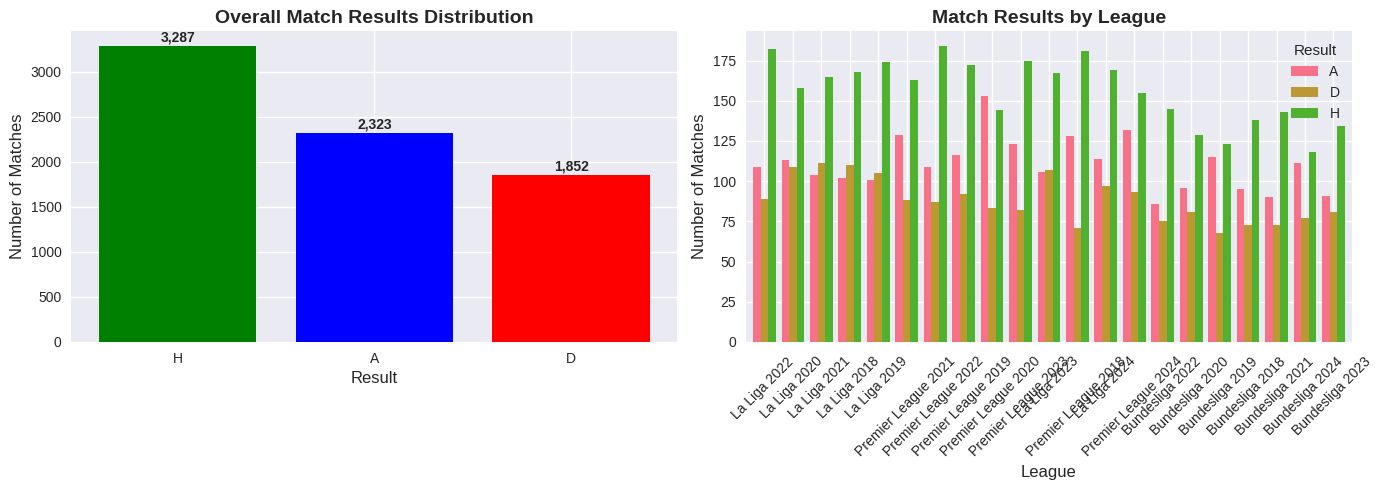

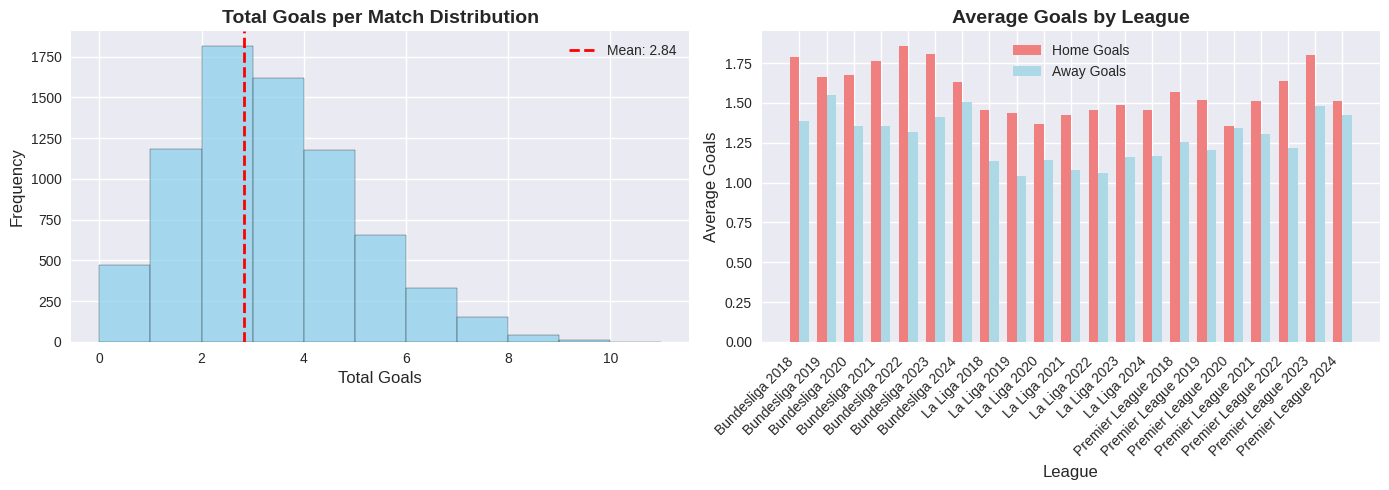

✅ Visualizations saved to output/figures/


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== CREATING VISUALIZATIONS ===")

os.makedirs('output/figures', exist_ok=True)

# Figure 1: Match results distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

result_counts = combined_data['match_result'].value_counts()
axes[0].bar(result_counts.index, result_counts.values, color=['green', 'blue', 'red'])
axes[0].set_title('Overall Match Results Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Result', fontsize=12)
axes[0].set_ylabel('Number of Matches', fontsize=12)
for i, v in enumerate(result_counts.values):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

league_order = combined_data['league'].value_counts().index
league_results = pd.crosstab(combined_data['league'], combined_data['match_result'])
league_results = league_results.reindex(league_order)
league_results.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Match Results by League', fontsize=14, fontweight='bold')
axes[1].set_xlabel('League', fontsize=12)
axes[1].set_ylabel('Number of Matches', fontsize=12)
axes[1].legend(title='Result', title_fontsize=11)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('output/figures/match_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Goals analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(combined_data['total_goals'], bins=range(0, 12),
             edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(combined_data['total_goals'].mean(), color='red',
                linestyle='--', linewidth=2, label=f'Mean: {combined_data["total_goals"].mean():.2f}')
axes[0].set_title('Total Goals per Match Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Goals', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()

avg_goals = combined_data.groupby('league')[['fthg', 'ftag']].mean()
x = range(len(avg_goals))
width = 0.35
axes[1].bar(x, avg_goals['fthg'], width, label='Home Goals', color='lightcoral')
axes[1].bar([i + width for i in x], avg_goals['ftag'], width, label='Away Goals', color='lightblue')
axes[1].set_title('Average Goals by League', fontsize=14, fontweight='bold')
axes[1].set_xlabel('League', fontsize=12)
axes[1].set_ylabel('Average Goals', fontsize=12)
axes[1].set_xticks([i + width/2 for i in x])
axes[1].set_xticklabels(avg_goals.index, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.savefig('output/figures/goals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to output/figures/")

In [15]:
print("=== GIT COMMIT ===")
print("Run these commands in Terminal to save your progress:\n")

print("""# In Terminal/PowerShell:
git add .
git commit -m "feat: complete preprocessing pipeline - processed {len(combined_data):,} matches"
git push origin main
""")

print(f"Your processed data includes:")
print(f"- {len(combined_data):,} total matches")
print(f"- {combined_data['league'].nunique()} leagues")
print(f"- {len(combined_data['season'].unique())} seasons")
print(f"- {combined_data['hometeam'].nunique():,} unique teams")

=== GIT COMMIT ===
Run these commands in Terminal to save your progress:

# In Terminal/PowerShell:
git add .
git commit -m "feat: complete preprocessing pipeline - processed {len(combined_data):,} matches"
git push origin main

Your processed data includes:
- 7,462 total matches
- 21 leagues
- 7 seasons
- 84 unique teams
